# 线性回归

## 简单线性回归

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

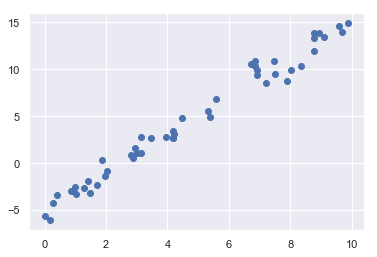

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

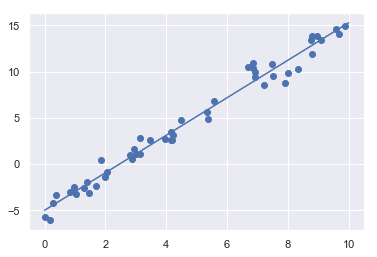

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

sklearn 通常会在参数后面加一条下划线

In [4]:
print('Model slope:   ', model.coef_[0])
print('Model intercept:  ',model.intercept_)

Model slope:    2.027208810360695
Model intercept:   -4.998577085553202


In [5]:
# 多维数据拟合
rng = np.random.RandomState(1)
X = 10 * rng.rand(100,3)
y = 0.5 + np.dot(X,[1.5,-2,1])

model.fit(X,y)
print(model.intercept_)
print(model.coef_)

0.5000000000000144
[ 1.5 -2.   1. ]


## 基函数回归

### 多项式基函数
就是将数据扩展两维多维，有些label就能够被特征更好的解释了

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2,3,4])
poly = PolynomialFeatures(3,include_bias=False)
poly.fit_transform(x[:,None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [7]:
# 通过管道将数据放入
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7),
                          LinearRegression())

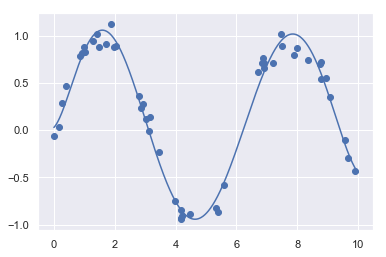

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:,np.newaxis],y)
yfit = poly_model.predict(xfit[:,np.newaxis])

plt.scatter(x,y)
plt.plot(xfit,yfit)

### 高斯基函数
在sklearn中没有明确给出，自己写一个（的确比较难理解）  
高斯基函数并不是高斯核函数  
原理：  
* 以该特征的N个间隔点为均值，相应宽度为标准差创建N个正态分布
* 每一个x，都可以求得在每个正态分布中出现的概率，从而从一维变成了N维
* 其实就是x之所以是x,以前认为只有一个分布确定，现在认为有好几个分布，尝试从更底层，去解决y的预测

In [17]:
# BaseEstimator,TransformerMixin 已经帮你把基础对象写好了,继承两个
from sklearn.base import BaseEstimator, TransformerMixin


class GaussianFeatures(BaseEstimator, TransformerMixin):
    """一维输入均匀分布的高斯特征"""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg**2, axis))

    def fit(self, X, y=None):
        # 在数据区间中创建N个高斯分布中心,注意是一维的，所以这么写
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        # 中心间隔
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        # 暂时还不是很明白为什么一定要 X[:,:,np,newaxis]这样传入，就一维来讲，直接传X也能取得想要的答案
        return self._gauss_basis(
            X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

(0, 10)

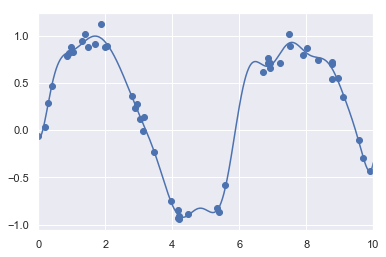

In [19]:
gauss_model = make_pipeline(GaussianFeatures(20),LinearRegression())

gauss_model.fit(x[:,np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x,y)
plt.plot(xfit, yfit)
plt.xlim(0,10)

基函数并没有什么特别的，如果对数据有什么直觉，那么就可以自己先定义一些基函数，然后像上面这样使用它们

## 正则化

在线性回归中引入基函数会让模型变得更加灵活，但是容易造成过拟合，如果选择了太多高斯基函数，最终的效果可能并不会好

(-1.5, 1.5)

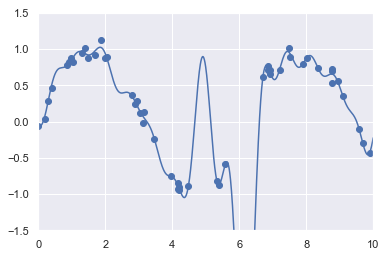

In [66]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())

model.fit(x[:,np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0,10)
plt.ylim(-1.5,1.5)

把基函数所有系数画出来，就能知道原因了

In [72]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location', ylabel='coefficoent', xlim=(0, 10))

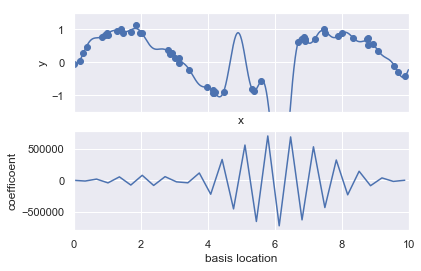

In [73]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())

basis_plot(model)

过拟合会导致系数放大，并且前后重合，即前一个系数是正的后一个就是负的，相互抵消，就等于没有效果  
因此需要加入正则

### 岭回归（L2范数正则化）

从上面的图可以看到，当出现过拟合系数开始重合的时候，系数往往会特别大，因此通过限制系数总体的平方和的大小，是可以有效消除过拟合的

$P = \alpha\sum^{N}_{n-1}\theta^2$

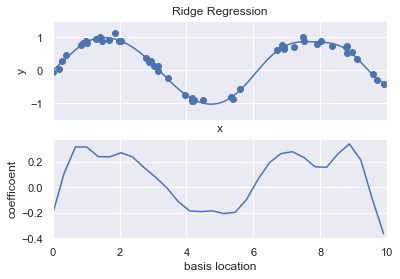

In [74]:
# 内置模型叫Ridge
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model,title='Ridge Regression')

### Lasso 正则化 （L1范数）

$P = \alpha\sum^N_{n-1}|\theta_n|$

结果往往会和岭回归差别很大，因为一个是限制了总体平方和的大小，更趋向于平均分，另一个是限制了绝对值，如果可能，更希望某些变量的系数趋向于0

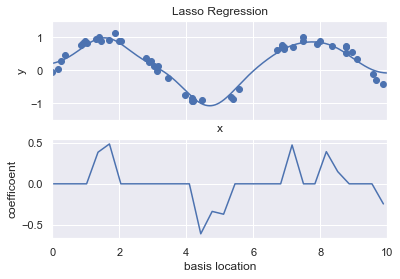

In [76]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha = 0.01))
basis_plot(model, title = 'Lasso Regression')

## 案例： 预测自行车流量

### 数据获取

In [80]:
# !curl -o ../data/FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1536k    0 1536k    0     0   361k      0 --:--:--  0:00:04 --:--:--  361k


In [83]:
import pandas as pd
counts = pd.read_csv('../data/FremontBridge.csv', index_col='Date',parse_dates=True)
weather = pd.read_csv('../data/BicycleWeather.csv', index_col='DATE',parse_dates=True)

### 数据处理

In [84]:
counts.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03 00:00:00,9.0,4.0
2012-10-03 01:00:00,6.0,4.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,3.0,2.0
2012-10-03 04:00:00,1.0,6.0


计算每一天的自行车的流量，将结果放到一张新表里

In [89]:
daily = counts.resample('d').sum()
daily['Total']=daily.sum(axis=1)
daily=daily[['Total']]

In [90]:
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


### 特征工程

表示星期几的变量

In [92]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [93]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


增加一列表示当天是否为节假日

In [97]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012','2016')
daily = daily.join(pd.Series(1,index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [98]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


白昼时间也会影响骑车的人数

In [105]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """计算指定日期的白昼时间"""
    days = (date - pd.datetime(2000,12,21)).days
    m = (1 - np.tan(np.radians(latitude)) * np.tan(np.radians(axis)*np.cos(days*2*np.pi/365.25)))
    return 24 * np.degrees(np.arccos(1 - np.clip(m,0,2)))/180

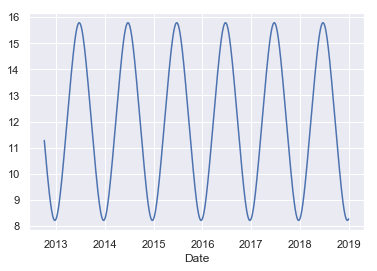

In [106]:
daily['daylight_hrs'] = list(map(hours_of_daylight,daily.index))
daily['daylight_hrs'].plot()

还可以增加平均气温和总降雨量

In [107]:
# 温度是按照十分之一摄氏度统计的，改回来
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# 降雨量也是按照十分之一mm统计的，转化为英寸
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [108]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


增加一个从1开始递增的计数器，表示已经过去了多少天

In [110]:
daily['annual'] = (daily.index - daily.index[0]).days/365
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [120]:
# weather 的数据只更新到 2015年，所以之后的数据不能用
daily.dropna(inplace=True)

### 训练模型

In [121]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']

X = daily[column_names]
y = daily['Total']

# 这里fit_intercept 选择了False， 因为根据问题分析来看，不需要
model = LinearRegression(fit_intercept=False)

model.fit(X, y)
daily['predicted'] = model.predict(X)

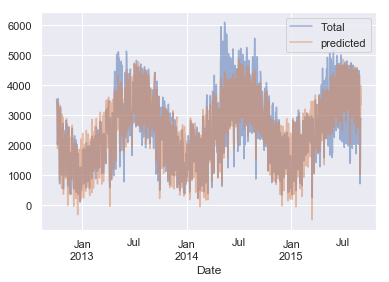

In [122]:
daily[['Total', 'predicted']].plot(alpha=0.5)

从上图可以看出，在夏天的时候预测的不是太好，应该有一些特征因素遗漏了

### 模型检验

#### 系数解释

In [123]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

#### 自举重采样

In [124]:
# 重采样，训练
from sklearn.utils import resample

np.random.seed(1)
err = np.std([model.fit(*resample(X,y)).coef_ for i in range(1000)], 0)

In [126]:
print(pd.DataFrame({'effect':params.round(0),
                   'error':err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0
